In [18]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import CDKMRippleCarryAdder, ZGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import pi, sqrt

- Variáveis: x, α, β, γ
- α, β e γ são inteiros 
- f(x) = x² mod β, com 0 ≤ x ≤ γ
- Objetivo buscar um f(x) = α
- Uf : |x⟩|α⟩ → |x⟩|α ⊕ (x² mod β)⟩

In [19]:
def cuccaro_adder_mod(n_bits):
    x1        = QuantumRegister(n_bits, 'X1')         # alvo x1
    x2        = QuantumRegister(n_bits, 'X2')         # x2 equivalente a x1
    reg_cin   = QuantumRegister(1, 'cin')             # carry-in
    reg_cout  = QuantumRegister(1, 'cout')            # carry-out para operações sobre x
    beta      = QuantumRegister(n_bits, 'beta')       # registrador preparado em |beta>
    anc       = QuantumRegister(1, 'anc')             # ancilla
        
    qc = QuantumCircuit(reg_cin, x1, x2, beta, reg_cout, anc, name = "cuccaro_adder_mod")
    
    adder_full = CDKMRippleCarryAdder(n_bits, kind='full', name='CDKM_full')
    adder_full_ctrl = adder_full.control(1)
    
    qc.barrier()
    qc.append(adder_full, reg_cin[:] + x2[:] + x1[:] + reg_cout[:])
    qc.append(adder_full.inverse(), reg_cin[:] + beta[:] + x1[:] + reg_cout[:])
    qc.barrier()
    qc.cx(reg_cout[0], anc[0])
    qc.barrier()
    qc.append(adder_full_ctrl, anc[:] + reg_cin[:] + beta[:] + x1[:] + reg_cout[:])
    qc.append(adder_full.inverse(), reg_cin[:] + x2[:] + x1[:] + reg_cout[:])

    qc.barrier()
    qc.x(reg_cout[0])
    qc.cx(reg_cout[0], anc[0])
    qc.x(reg_cout[0])
    qc.barrier()
    qc.append(adder_full, reg_cin[:] + x2[:] + x1[:] + reg_cout[:])
    qc.barrier()

    return qc

In [20]:
def mult1(n_bits):
    b = QuantumRegister(n_bits, 'b')
    a = QuantumRegister(n_bits, 'a')
    anc_a = QuantumRegister(n_bits - 1, "anc_a")
    anc_res = QuantumRegister(2 * n_bits, "anc_res")
    
    reg_cin   = QuantumRegister(1, 'cin')   
    
    qc = QuantumCircuit(reg_cin ,b, a, anc_a, anc_res, name = "mult1")
    
    for i in range(n_bits):
        adder_full = CDKMRippleCarryAdder(n_bits + i, kind='full', name='CDKM_full')
        adder_full_ctrl = adder_full.control(1)
        qc.append(adder_full_ctrl, b[i:i+1] + reg_cin[:] + anc_a[:i] + a[:] + anc_res[:n_bits+i + 1])
    
    return qc

In [ ]:
def div(n_bits):
    b = QuantumRegister(n_bits, 'b') # Módulo
    a = QuantumRegister(2 * n_bits, 'A')
    x = QuantumRegister(n_bits, "x")
    anc_res = QuantumRegister(n_bits - 1, "anc_res")
    
    reg_cin   = QuantumRegister(1, 'cin')
    
    qc = QuantumCircuit(reg_cin, b, a, x, anc_res, name = "div")

    for i in range(n_bits):
        adder_full = CDKMRippleCarryAdder(2 * n_bits - i - 1, kind='full', name='CDKM_full')
        adder_full_ctrl = adder_full.control(1, ctrl_state='0')
        qc.append(adder_full.inverse(), reg_cin[:] + anc_res[:n_bits - i - 1] + b[:] + a[:2 * n_bits - i])
        qc.cx(a[2 * n_bits - i - 1 : 2 * n_bits - i], x[n_bits - i - 1: n_bits - i], ctrl_state='0')
        qc.append(adder_full_ctrl, x[n_bits - i - 1 : n_bits - i] + reg_cin[:] + anc_res[:n_bits - i - 1] + b[:] + a[:2 * n_bits - i])
    
    return qc

In [22]:
def mult_mod1(n_bits):
    a = QuantumRegister(n_bits, "a")
    b = QuantumRegister(n_bits, "b")
    anc = QuantumRegister(2 * n_bits, "anc")
    anc_a = QuantumRegister(n_bits-1, "anc_a")
    anc_res = QuantumRegister(n_bits, "anc_res")
    
    N = QuantumRegister(n_bits, "N")
    anc_res_aux = QuantumRegister(n_bits - 1, "anc_res_aux")
    x = QuantumRegister(n_bits, "x")
    
    reg_cin = QuantumRegister(1, 'cin')
    
    qc = QuantumCircuit(a, b, anc, anc_res, N, reg_cin, anc_a, anc_res_aux, x, name = "mult_mod1")
    
    for i in range(n_bits-2):
        qc.cx(a[i], b[i])
    
    qc.x(N)
  
    qc.append(mult1(n_bits), reg_cin[:] + a[:] + b[:] + anc_a[:] + anc[:])
    qc.append(div(n_bits), reg_cin[:] + N[:] + anc[:] + x[:] + anc_res_aux[:])
    for i in range(n_bits):
        qc.cx(anc[i], anc_res[i])
    
    qc.append(div(n_bits).inverse(), reg_cin[:] + N[:] + anc[:] + x[:] + anc_res_aux[:])
    qc.append(mult1(n_bits).inverse(), reg_cin[:] + a[:] + b[:] + anc_a[:] + anc[:])
    
    return qc

In [23]:
def inversaoSobreMedia(n_bits, controlado=False):
  q_reg = QuantumRegister(n_bits)

  if controlado:
    c_reg = QuantumRegister(1)

    qc = QuantumCircuit(c_reg, q_reg, name="C-inv-media")

    qc.ch(c_reg[0], q_reg)
    qc.cx(c_reg[0], q_reg)
    qc.append(ZGate().control(num_ctrl_qubits=n_bits, ctrl_state="1"*(n_bits-1)+"1"), [c_reg] + q_reg[:])
    qc.cx(c_reg[0], q_reg)
    qc.ch(c_reg[0], q_reg)
    
  else:
    qc = QuantumCircuit(q_reg, name="inv-media")

    qc.h(q_reg)
    qc.x(q_reg)
    qc.append(ZGate().control(num_ctrl_qubits=n_bits-1, ctrl_state="1"*(n_bits-1)), q_reg)
    qc.x(q_reg)
    qc.h(q_reg)

  return qc

In [24]:
def grover(n_bits):
    a = QuantumRegister(n_bits, "a")
    b = QuantumRegister(n_bits, "b")
    anc = QuantumRegister(2 * n_bits, "anc")
    anc_a = QuantumRegister(n_bits-1, "anc_a")
    anc_res = QuantumRegister(n_bits, "anc_res")

    N = QuantumRegister(n_bits, "N")
    anc_res_aux = QuantumRegister(n_bits - 1, "anc_res_aux")
    x = QuantumRegister(n_bits, "x")

    reg_cin = QuantumRegister(1, 'cin')

    alpha = 37

    alvo = QuantumRegister(1, "alvo")

    qc = QuantumCircuit(reg_cin, a, b, anc, anc_res, N, anc_a, anc_res_aux, x, alvo, name="Grover")

    qc.append(mult_mod1(n_bits), a[:] + b[:] + anc[:] + anc_res[:] + N[:] + reg_cin[:] + anc_a[:] + anc_res_aux[:] + x[:])

    qc.barrier()

    for i in range(alpha.bit_length()):
        if bin(alpha)[2:].zfill(alpha.bit_length())[::-1][i] == "1":
            qc.x(anc_res[i])
    qc.barrier()

    qc.h(alvo)
    qc.mcx(anc_res, alvo, ctrl_state="0"*n_bits)
    qc.h(alvo)
    
    qc.barrier()

    for i in range(alpha.bit_length()):
        if bin(alpha)[2:].zfill(alpha.bit_length())[::-1][i] == "1":
            qc.x(anc_res[i])

    qc.append(mult_mod1(n_bits).inverse(), a[:] + b[:] + anc[:] + anc_res[:] + N[:] + reg_cin[:] + anc_a[:] + anc_res_aux[:] + x[:])

    qc.append(inversaoSobreMedia(n_bits-2), a[:n_bits-2])
    
    return qc

53


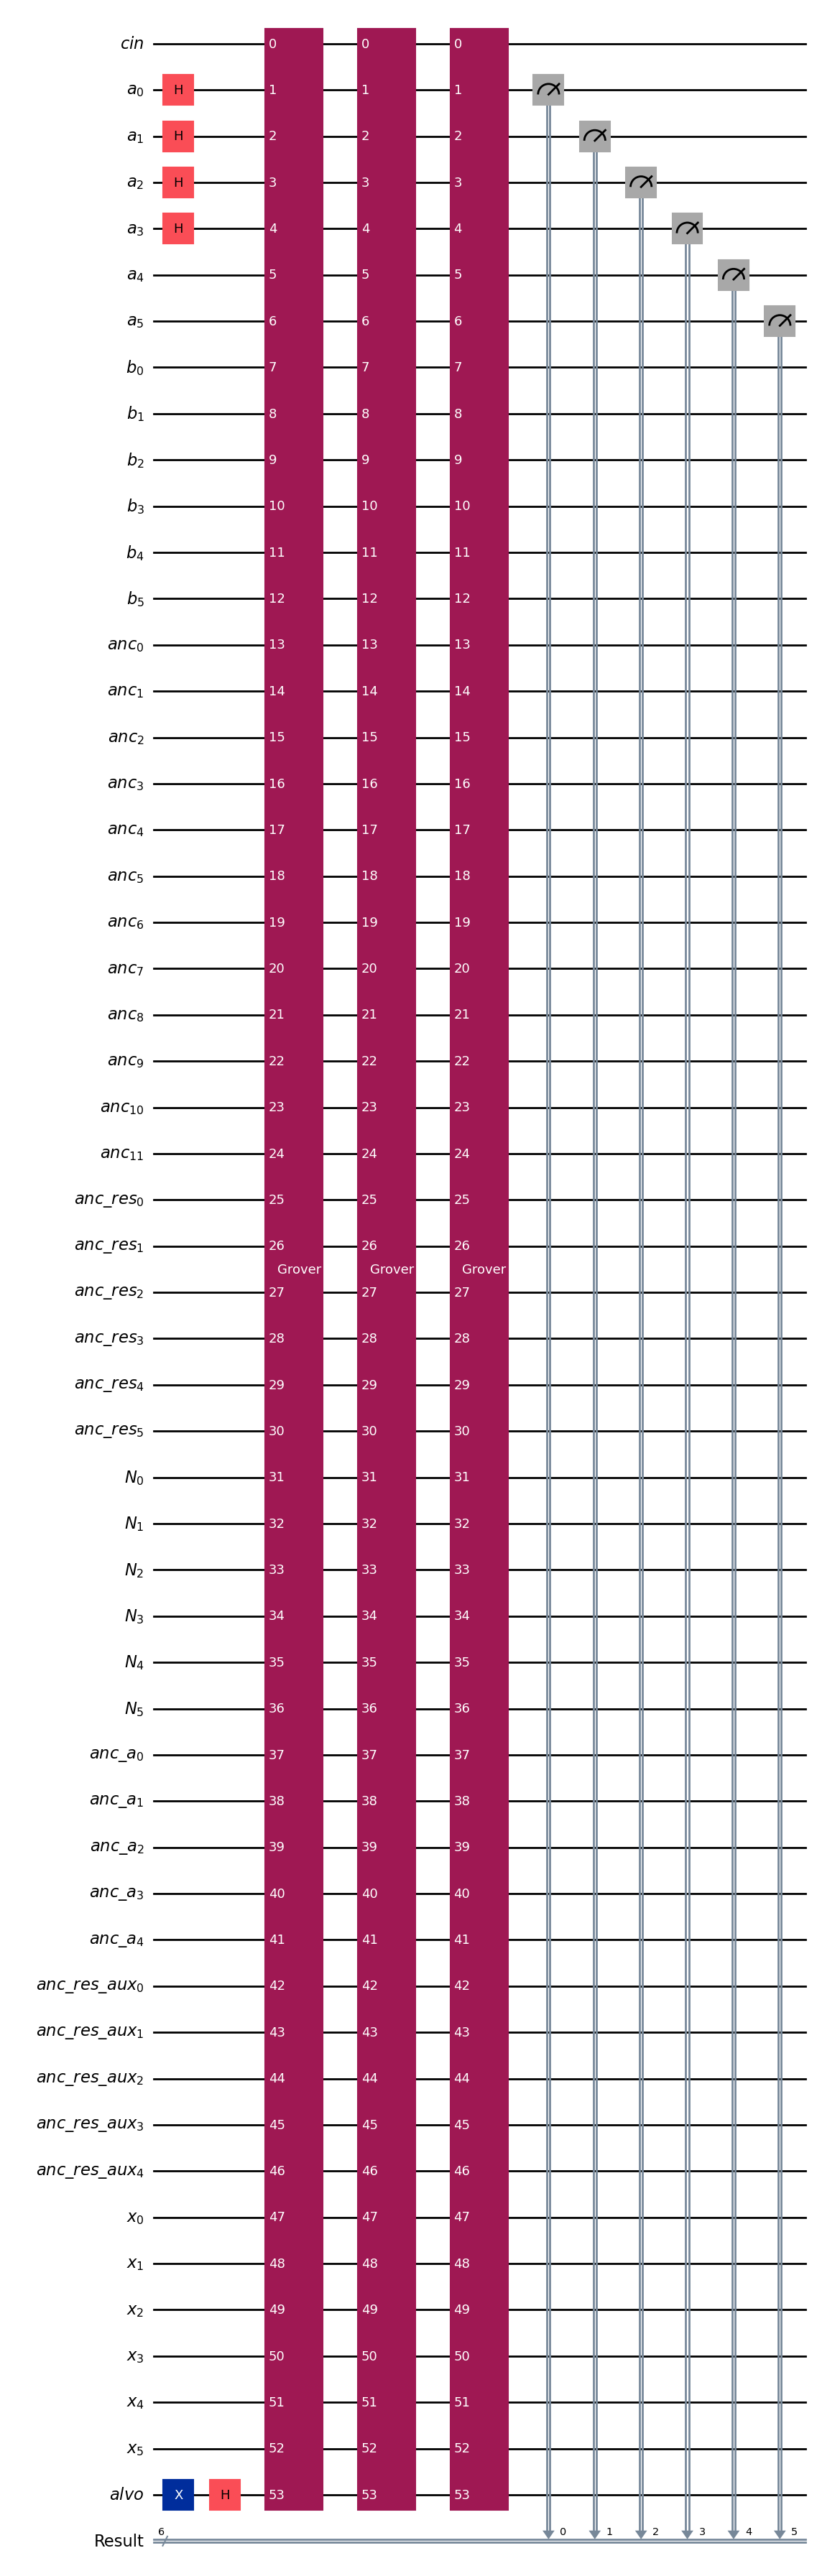

In [25]:
n_bits = 6

a = QuantumRegister(n_bits, "a")
b = QuantumRegister(n_bits, "b")
anc = QuantumRegister(2 * n_bits, "anc")
anc_a = QuantumRegister(n_bits-1, "anc_a")
anc_res = QuantumRegister(n_bits, "anc_res")

N = QuantumRegister(n_bits, "N")
anc_res_aux = QuantumRegister(n_bits - 1, "anc_res_aux")
x = QuantumRegister(n_bits, "x")

reg_cin = QuantumRegister(1, 'cin')

alvo = QuantumRegister(1, "alvo")

result = ClassicalRegister(n_bits, "Result")

qc = QuantumCircuit(reg_cin, a, b, anc, anc_res, N, anc_a, anc_res_aux, x, result, alvo)

tamanho = n_bits - 2

for i in range(tamanho):
    qc.h(a[i])

qc.x(alvo)
qc.h(alvo)

print(len(a[:] + b[:] + anc[:] + anc_res[:] + N[:] + reg_cin[:] + anc_a[:] + anc_res_aux[:] + x[:]))

for i in range(round((pi/4) * sqrt(2**tamanho))):
    qc.append(grover(n_bits), reg_cin[:] + a[:] + b[:] + anc[:] + anc_res[:] + N[:] + anc_a[:] + anc_res_aux[:] + x[:] + alvo[:])

qc.measure(a, result)

qc.draw("mpl")


In [26]:
backend = AerSimulator(method="matrix_product_state")
tqc = transpile(qc, backend=backend, optimization_level=3)
res = backend.run(tqc, shots=1<<15).result()
counts = res.get_counts(tqc) 

In [27]:
mod = pow(2, n_bits) - 1
tam = pow(2, n_bits - 2) - 1
print(mod, tam)
alpha = 37
for i in range(tam):
    # print(i, pow(i, 2, mod))
    if alpha == pow(i, 2, mod):
        print(f"X = {i}")

63 15
X = 10



Resultados da medição para x² mod 63:
{10: 16841, 14: 1095, 4: 1096, 13: 1067, 3: 1043, 12: 1065, 7: 1078, 2: 1017, 9: 1065, 0: 1075, 11: 1077, 1: 1055, 6: 1026, 8: 1056, 5: 1030, 15: 1082}


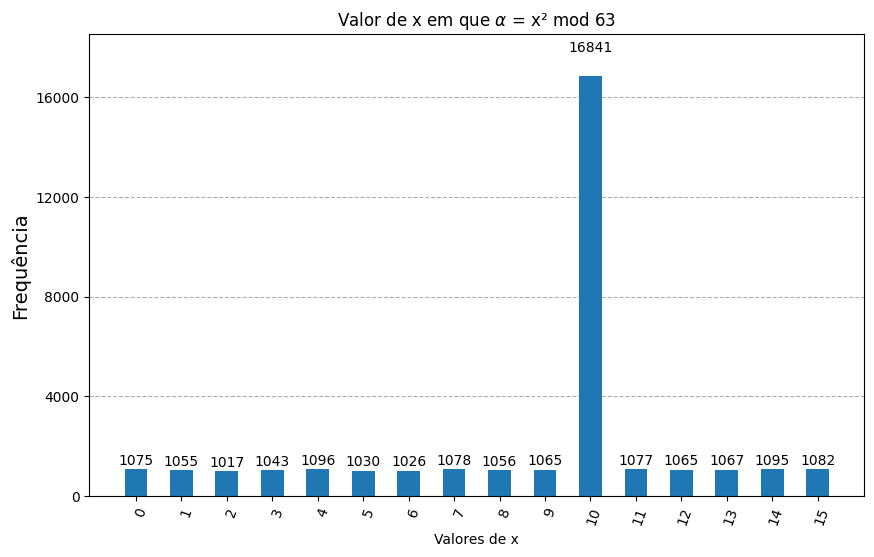

In [28]:
processed_counts = {}
for bin_result, count in counts.items():
    decimal_result = int(bin_result, 2) 
    processed_counts[decimal_result] = processed_counts.get(decimal_result, 0) + count


print(f"\nResultados da medição para x² mod {2**n_bits - 1}:")
print(processed_counts)

fig, ax = plt.subplots(figsize=(10, 6))

plot_histogram(processed_counts, title=f'Valor de x em que $\\alpha$ = x² mod {2**n_bits - 1}', ax=ax)

ax.set_xlabel(f'Valores de x')
ax.set_ylabel('Frequência')

plt.show()